In [29]:
import os
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from keras.applications import VGG19
from keras.layers import Dense, Flatten, Input
from keras.optimizers import Adam
from keras.models import Model, load_model
from matplotlib import pyplot as plt
import csv
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [26]:
images_path = "dataset/images"
coords_path = "dataset/labels.csv"
images_names = os.listdir(images_path)
csv_data = {}
with open(coords_path, "r") as file:
    reader = csv.reader(file)
    for row in reader:
        csv_data[row[0]] = [float(row[1]), float(row[2]), float(row[3]),  float(row[4])]
images = []
coords = []
for image_name in images_names:
    img = cv2.imread(os.path.join(images_path, image_name))
    coord = csv_data[image_name[:-4]]
    img = img_to_array(img)
    images.append(img)
    coords.append(coord)
images = np.array(images, dtype="float32") / 255.0
coords = np.array(coords, dtype="float32")
split = train_test_split(images, coords, images_names, test_size=0.1, random_state=123)
(train_images, test_images) = split[:2]
(train_coords, test_coords) = split[2:4]
(train_names, test_names) = split[4:]
split = train_test_split(test_images, test_coords, test_names, test_size=0.5, random_state=123)
(test_images, control_images) = split[:2]
(test_coords, control_coords) = split[2:4]
(test_names, comtrol_names) = split[4:]

In [27]:
vgg = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(177, 230, 3)))
vgg.trainable = False
flatten = Flatten()(vgg.output)
pr_coord = Dense(128, activation="relu")(flatten)
pr_coord = Dense(64, activation="relu")(pr_coord)
pr_coord = Dense(32, activation="relu")(pr_coord)
pr_coord = Dense(4, activation="sigmoid")(pr_coord)

model = Model(inputs=vgg.inputs, outputs=pr_coord)
model.compile(loss="mse", optimizer=Adam())
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 177, 230, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 177, 230, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 177, 230, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 115, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 115, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 115, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 57, 128)       0   

In [28]:
history = model.fit(
    train_images, train_coords,
    validation_data=(test_images, test_coords),
    batch_size=32,
    epochs=25,
    verbose=1)

KeyboardInterrupt: 

In [ ]:
model.save("iris_model.h5", save_format="h5")

In [ ]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Loss')

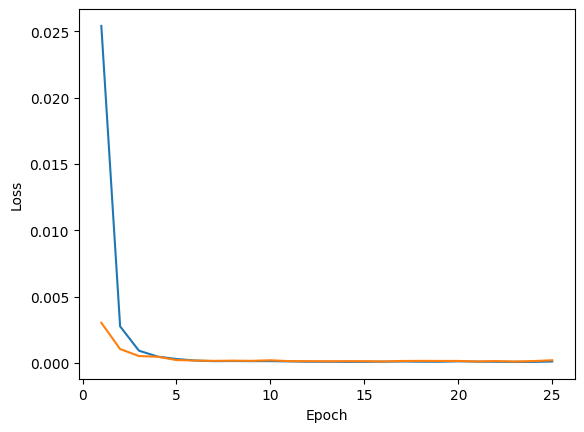

In [ ]:
plt.plot(np.arange(1, len(history.history["loss"])+1), history.history["loss"], label="train_loss")
plt.plot(np.arange(1, len(history.history["val_loss"])+1), history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

['IMG20231216165024.jpg', 'IMG20231216164301.jpg', 'IMG20231216164914_01.jpg', 'IMG20231216164935.jpg', 'IMG20231216164300.jpg', 'IMG20231216101004_01.jpg', 'IMG20231216164653_01.jpg', 'IMG20231216164335_01.jpg', 'IMG20231216164739_01.jpg', 'IMG20231216164919_01.jpg', 'IMG20231216164915.jpg', 'IMG20231216164902_01.jpg', 'IMG20231216164937_01.jpg', 'IMG20231216101014_01.jpg', 'IMG20231216164329.jpg', 'IMG20231216164730.jpg', 'IMG20231216101010.jpg', 'IMG20231216164918.jpg', 'IMG20231216164718_01.jpg', 'IMG20231216164712.jpg', 'IMG20231216164728_01.jpg', 'IMG20231216164912_01.jpg']
1/1 [==============================] - 0s 278ms/step
[0.55579275 0.5976562  0.35666987 0.588141  ]
IMG20231216164329.jpg


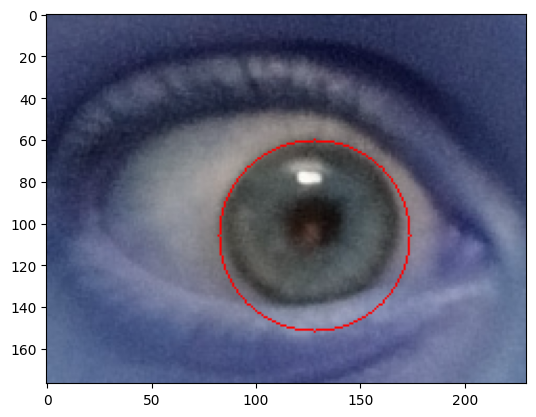

In [34]:
model1 = load_model("iris_model.h5")
control_image_name = comtrol_names[14]
print(comtrol_names)
control_image = cv2.imread(os.path.join(images_path, control_image_name))
in_image = img_to_array(control_image)
in_image = np.array(in_image, dtype="float32") / 255.0
in_image = np.expand_dims(in_image, axis=0)
pred = model1.predict(in_image)[0]
print(pred)
h, w, _ = control_image.shape
tx, ty, bx, by = pred[0], pred[1], pred[2], pred[3]
tx *= w
ty *= h
bx *= w
by *= h
tx = round(tx)
ty = round(ty)
bx = round(bx)
by = round(by)
rad = round(((tx-bx)**2+ (ty-by)**2)**.5)
print(control_image_name)
# cv2.rectangle(control_image, (tx, ty), (bx, by), (0, 255, 0))
cv2.circle(control_image, (tx, ty), rad, (255, 0, 0))
plt.imshow(control_image)